In [0]:
# mountinh the google drive to read the source 
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.4f' % x)
import seaborn as sns
sns.set_context("paper", font_scale=1.3)
sns.set_style('white')
import warnings
warnings.filterwarnings('ignore')
from time import time
import matplotlib.ticker as tkr
from scipy import stats
from statsmodels.tsa.stattools import adfuller
from sklearn import preprocessing
from statsmodels.tsa.stattools import pacf
%matplotlib inline

import math
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Dropout
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from keras.callbacks import EarlyStopping

In [0]:
"""
Processing the data
"""
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler


def process_data(train, test, lags):
    """Process data
    Reshape and split train\test data.
    # Arguments
        train: String, name of .csv train file.
        test: String, name of .csv test file.
        lags: integer, time lag.
    # Returns
        X_train: ndarray.
        y_train: ndarray.
        X_test: ndarray.
        y_test: ndarray.
        scaler: StandardScaler.
    """
    attr = 'Flow (Veh/Hour)'
    df1 = pd.read_csv(train, encoding='utf-8').fillna(0)
    df2 = pd.read_csv(test, encoding='utf-8').fillna(0)

    # scaler = StandardScaler().fit(df1[attr].values)
    scaler = MinMaxScaler(feature_range=(0, 1)).fit(df1[attr].values.reshape(-1, 1))
    flow1 = scaler.transform(df1[attr].values.reshape(-1, 1)).reshape(1, -1)[0]
    flow2 = scaler.transform(df2[attr].values.reshape(-1, 1)).reshape(1, -1)[0]

    train, test = [], []
    for i in range(lags, len(flow1)):
        train.append(flow1[i - lags: i + 1])
    for i in range(lags, len(flow2)):
        test.append(flow2[i - lags: i + 1])

    train = np.array(train)
    test = np.array(test)
    np.random.shuffle(train)

    X_train = train[:, :-1]
    y_train = train[:, -1]
    X_test = test[:, :-1]
    y_test = test[:, -1]

    return X_train, y_train, X_test, y_test, scaler

In [0]:
X_train, Y_train, X_test, Y_test, scaler = process_data('/content/drive/My Drive/Colab Notebooks/train_pems.csv', '/content/drive/My Drive/Colab Notebooks/test_pems.csv',lags=12)

In [23]:
X_train.shape
Y_train.shape

(2147,)

In [0]:
# reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

In [28]:
model = Sequential()
model.add(LSTM(100, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

history = model.fit(X_train, Y_train, epochs=20, batch_size=70, validation_data=(X_test, Y_test), 
                    callbacks=[EarlyStopping(monitor='val_loss', patience=10)], verbose=1, shuffle=False)

# Training Phase
model.summary()

Train on 2147 samples, validate on 1476 samples
Epoch 1/20
2147/2147 [==============================] - 1s 362us/step - loss: 0.1101 - val_loss: 0.0581
Epoch 2/20
2147/2147 [==============================] - 0s 67us/step - loss: 0.0339 - val_loss: 0.0199
Epoch 3/20
2147/2147 [==============================] - 0s 61us/step - loss: 0.0151 - val_loss: 0.0112
Epoch 4/20
2147/2147 [==============================] - 0s 63us/step - loss: 0.0102 - val_loss: 0.0091
Epoch 5/20
2147/2147 [==============================] - 0s 67us/step - loss: 0.0092 - val_loss: 0.0081
Epoch 6/20
2147/2147 [==============================] - 0s 62us/step - loss: 0.0085 - val_loss: 0.0074
Epoch 7/20
2147/2147 [==============================] - 0s 70us/step - loss: 0.0080 - val_loss: 0.0066
Epoch 8/20
2147/2147 [==============================] - 0s 63us/step - loss: 0.0073 - val_loss: 0.0064
Epoch 9/20
2147/2147 [==============================] - 0s 73us/step - loss: 0.0068 - val_loss: 0.0058
Epoch 10/20
2147/2147 [=

In [29]:
# make predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
# invert predictions
train_predict = scaler.inverse_transform(train_predict)
Y_train = scaler.inverse_transform([Y_train])
test_predict = scaler.inverse_transform(test_predict)
Y_test = scaler.inverse_transform([Y_test])

print('Train Mean Absolute Error:', mean_absolute_error(Y_train[0], train_predict[:,0]))
print('Train Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_train[0], train_predict[:,0])))
print('Test Mean Absolute Error:', mean_absolute_error(Y_test[0], test_predict[:,0]))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_test[0], test_predict[:,0])))

Train Mean Absolute Error: 385.6768878094252
Train Root Mean Squared Error: 499.4775876979315
Test Mean Absolute Error: 369.23022117185076
Test Root Mean Squared Error: 477.94480917014175


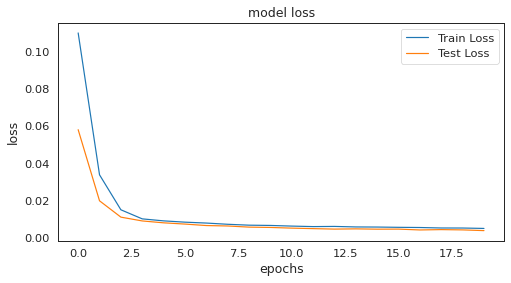

In [30]:
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show();